# Title

Importing relevant libraries

In [1]:
import numpy as num
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as skl
import xgboost
import gensim
import json
import re
import string
import seaborn as sns

Taking a fraction of the entire dataset

In [2]:
trainingAmount = 400000
testAmount = 100000

with open('review.json') as raw:
    with open('training.json', 'w') as trainingSet: 
        for x in range(trainingAmount):
            line = raw.readline()
            trainingSet.write(line)
    with open('test.json', 'w') as testSet: 
        for x in range(trainingAmount, trainingAmount+testAmount):
            line = raw.readline()
            testSet.write(line)

In [3]:
df_train = pd.read_json('training.json', lines=True)
df_test = pd.read_json('test.json', lines=True)

df_test = df_test.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_test = df_test.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train = df_train.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_train = df_train.reindex(['text','stars','useful','funny','cool'], axis=1)

In [4]:
def clean(text):
    from nltk.stem import WordNetLemmatizer
    from nltk.stem.snowball import SnowballStemmer
    from nltk.tokenize import word_tokenize
    
#     lemmatizer = WordNetLemmatizer()
#     for word in text:
#         word = lemmatizer.lemmatize(word)
    
     # Empty question
    if type(text) != str:
        return ''
    
#     nltk.corpus.stopwords.words('english')
    
    
    text = re.sub("I\'ll", "I will", text)
    text = re.sub("I\'m", "I am", text)

    text = text.lower()
    
    text = re.sub(" what\'s ", " what is ", text)
    text = re.sub(" that\'s ", " that is ", text)
    
    text = re.sub("\'s", "", text)
    text = re.sub('\n', ' ', text)
    
    
    text = re.sub(" whats ", " what is ", text)
    text = re.sub(" thats ", " that is ", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("n\'t", ' not', text)

    text = re.sub('[' + string.punctuation + ']', '', text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)

    
#     stemmer = SnowballStemmer('english')
#     textList = word_tokenize(text)
#     text = ''
#     for word in textList:
#         text += stemmer.stem(word) + ' '
    
    
    # Return a list of words
    return text

In [5]:
df_train['length'] = df_train['text'].apply(len)
df_test['length'] = df_test['text'].apply(len)

In [6]:
df_train.describe()

,stars,useful,funny,cool,length
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000
mean,3.730208,1.300900,0.451282,0.549493,591.225208
std,1.455814,2.956285,1.676008,2.029620,553.155861
min,1.000000,0.000000,0.000000,0.000000,1.000000
25%,3.000000,0.000000,0.000000,0.000000,234.000000
50%,4.000000,0.000000,0.000000,0.000000,419.000000
75%,5.000000,1.000000,0.000000,0.000000,751.000000
max,5.000000,135.000000,85.000000,108.000000,5000.000000


Cleaning the data

In [7]:
df_train['cleaned_text'] = df_train['text'].apply(clean)
df_test['cleaned_text'] = df_test['text'].apply(clean)

Saving all the necessary data in arrays

In [8]:
train = df_train['cleaned_text'].values
test = df_test['cleaned_text'].values
trainStars = df_train['stars'].values
testStars = df_test['stars'].values

## BOW model with Naïve Bayes Classifier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
trainVecs = vectorizer.fit_transform(train)
testVecs = vectorizer.transform(test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()
classifierNB.fit(trainVecs, trainStars)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
testStars_predicted = classifierNB.predict(testVecs)
print(classifierNB.score(testVecs, testStars)*100, "%")

60.407 %


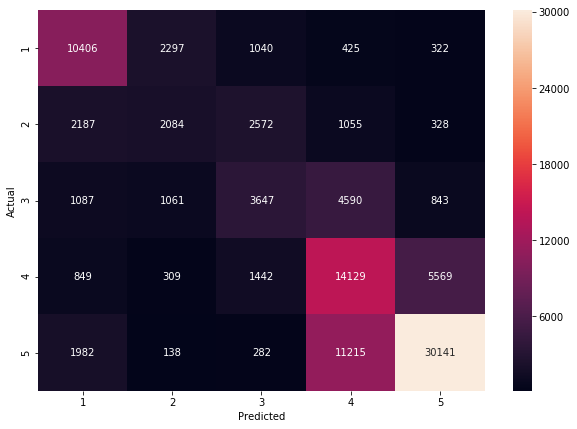

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
import collections
distance = num.abs(testStars - testStars_predicted)
collections.Counter(distance)

Counter({0: 60407, 1: 30933, 2: 4616, 4: 2304, 3: 1740})

## Word2Vec model

In [ ]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

train_tokenized = [word_tokenize(token) for token in train]
test_tokenized = [word_tokenize(token) for token in test]

word2vec = Word2Vec(train_tokenized)

word2vec.init_sims(replace=True)

In [ ]:
def sent2vec(reviewTok):
    vecSize = len(word2vec[reviewTok[0][0]])
    reviewVec = []
    for sentence in reviewTok:
        vectorSum = num.zeros(vecSize)
        empty = True
        for token in sentence:
            if token in word2vec:
                vectorSum += word2vec[token]
                empty = False
        if not empty:
            vectorSum = vectorSum / num.sqrt((vectorSum ** 2).sum())
        reviewVec.append(vectorSum)
    return num.array(reviewVec)

In [ ]:
train_vectors = sent2vec(train_tokenized)
test_vectors = sent2vec(test_tokenized)

In [ ]:
from xgboost import XGBClassifier
xgbclassifier = XGBClassifier()
xgbclassifier.fit(train_vectors, trainStars)

In [ ]:
print(xgbclassifier.score(test_vectors, testStars)*100, '%')

***

### Looking for relation between text length and rating
Tests with charts

In [ ]:
g = sns.FacetGrid(data=df_test, col='stars')
g.map(plt.hist, 'length', bins=50)

In [ ]:
sns.boxplot(x='stars', y='length', data=df_test)

In [ ]:
df_test.describe()

In [ ]:
starProp_train = df_train.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_train['percentage'] = starProp_train['cleaned_text'] / df_train.shape[0] * 100
starProp_train


In [ ]:
starProp_test = df_test.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_test['percentage'] = starProp_test['cleaned_text'] / df_test.shape[0] * 100
starProp_test


Training and test set have same proportions! :-)

ideas:
- make a numbers token <NUMBER>
- stem the words
- remove stopwords
- create a personal noun token <PERSONALNOUN>

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

stemmer = SnowballStemmer('english')

review = word_tokenize(df_test['cleaned_text'].values[4])
stemmed = ''
for word in review:
    stemmed += stemmer.stem(word) + ' '


In [ ]:
df_test